In [285]:
%load_ext autoreload
%autoreload 2


import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from dataloader import MedicalDataset,ImageTransform,make_datapath_list,split_dataset
from utils import imshow
from train import train_model
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 장치:", device)

사용 장치: cuda:0


## 1. 훈련 시 이미지 전처리 동작 확인

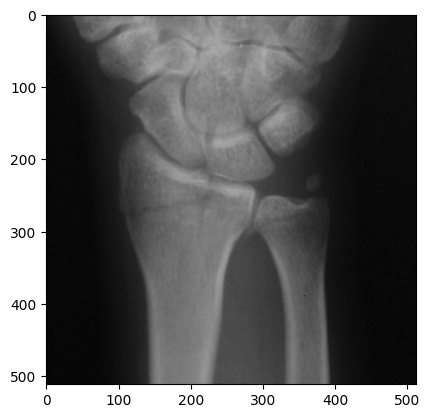

In [287]:
# 1. 이미지 읽기
image_file_path = '../dataset/0pre/DLRF512px_001_preap.jpg'
img = Image.open(image_file_path) #[높이],[너비], [색상 채널 RGB]

# 2. 원본 이미지 표시
plt.imshow(img)
plt.show()

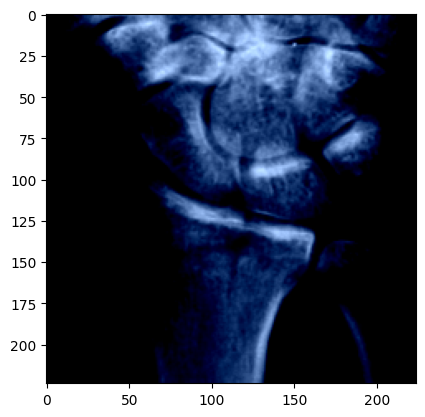

In [288]:
# 3. 이미지 전처리 및 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase="train") # torch.Size([3, 224, 224]) ([색상채널], [높이], [너비])


#(색상, 높이 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

## 2. 전체데이터셋 불러오기

In [289]:
preap_surgery, preap_no_surgery, prelat_surgery, prelat_no_surgery = make_datapath_list('../dataset')

In [290]:
# 1. 정면 데이터셋을 train과 test로 분리한다.
preap_surgery_trainA, preap_surgery_test, preap_no_surgery_trainA, preap_no_surgery_test = split_dataset(
    preap_surgery, preap_no_surgery, split_ratio=0.8)

# 2. 측면 데이터셋을 train과 test로 분리한다.
prelat_surgery_trainA, prelat_surgery_test, prelat_no_surgery_trainA, prelat_no_surgery_test = split_dataset(
    prelat_surgery, prelat_no_surgery, split_ratio=0.8)

# 3. 정면 train dataset 중에 validation dataset을 확보한다. 
preap_surgery_train, preap_surgery_val, preap_no_surgery_train, preap_no_surgery_val = split_dataset(
    preap_surgery_trainA, preap_no_surgery_trainA, split_ratio=0.8)

# 4. 측면 train dataset 중에 validation dataset을 확보한다.
prelat_surgery_train, prelat_surgery_val, prelat_no_surgery_train, prelat_no_surgery_val = split_dataset(
    prelat_surgery_trainA, prelat_no_surgery_trainA, split_ratio=0.8)


# 5. 훈련데이터와 테스트 데이터를 불러온다.
train_list_preap = preap_surgery_train + preap_no_surgery_train
train_list_prelat = prelat_surgery_train + prelat_no_surgery_train

val_list_preap = preap_surgery_val + preap_no_surgery_val
val_list_prelat = prelat_surgery_val + prelat_no_surgery_val

test_list_preap = preap_surgery_test + preap_no_surgery_test
test_list_prelat = prelat_surgery_test + prelat_no_surgery_test

print("정면 훈련 데이터 == ",len(train_list_preap))
print("측면 훈련 데이터 == ",len(train_list_prelat))

print("정면 검증 데이터 == ",len(val_list_preap))
print("측면 검증 데이터 == ",len(val_list_prelat))

# [참고] 현재 테스트 데이터에서 수술필요(1)와 수술불필요(0)의 비율이 맞지 않는다
print("정면 테스트 데이터 == ",len(test_list_preap))
print("측면 테스트 데이터 == ",len(test_list_prelat))

정면 훈련 데이터 ==  400
측면 훈련 데이터 ==  400
정면 검증 데이터 ==  102
측면 검증 데이터 ==  102
정면 테스트 데이터 ==  259
측면 테스트 데이터 ==  259


In [291]:
# 1. 정면 사진의 훈련데이터셋 구성
preap_train_dataset = MedicalDataset(img_list=train_list_preap, transform=ImageTransform(resize, mean, std), phase = 'train')

# 1.1 정면 사진의 Val 데이터셋 구성
preap_val_dataset = MedicalDataset(img_list=val_list_preap, transform=ImageTransform(resize, mean, std), phase = 'val')

# 1.2 정면 사진의 Test 데이터셋 구성
preap_test_dataset = MedicalDataset(img_list=test_list_preap, transform=ImageTransform(resize, mean, std), phase = 'val')


# 2. 측면 사진의 훈련데이터셋 구성
prelat_train_dataset = MedicalDataset(img_list=train_list_prelat, transform=ImageTransform(resize, mean, std), phase = 'train')

# 2.2 측면 사진의 Val 데이터셋 구성
prelat_val_dataset = MedicalDataset(img_list=val_list_prelat, transform=ImageTransform(resize, mean, std), phase = 'val')

# 2.2 측면 사진의 Test 데이터셋 구성
prelat_test_dataset = MedicalDataset(img_list=test_list_prelat, transform=ImageTransform(resize, mean, std), phase = 'val')

## 3. 데이터 로더 작성

In [292]:
batch_size = 5

# 1. 정면 사진의 데이터로더 구성
preap_train_dataloader = torch.utils.data.DataLoader(preap_train_dataset, batch_size=batch_size, shuffle=True)
preap_val_dataloader = torch.utils.data.DataLoader(preap_val_dataset, batch_size=batch_size, shuffle=True)
preap_test_dataloader = torch.utils.data.DataLoader(preap_test_dataset, batch_size=batch_size, shuffle=True)

# 2. 측면 사진의 데이터로더 구성
prelat_train_dataloader = torch.utils.data.DataLoader(prelat_train_dataset, batch_size=batch_size, shuffle=True)
prelat_val_dataloader = torch.utils.data.DataLoader(prelat_train_dataset, batch_size=batch_size, shuffle=True)
prelat_test_dataloader = torch.utils.data.DataLoader(prelat_test_dataset, batch_size=batch_size, shuffle=True)

# 3. 사전형 변수에 정리
preap_dataloaders_dict = {"train" : preap_train_dataloader, "val" : preap_val_dataloader}
prelat_dataloaders_dict = {"train" : prelat_train_dataloader, "val" : prelat_val_dataloader}

# 4. 동작 확인
batch_iterator = iter(preap_dataloaders_dict["train"])
inputs,label = next(batch_iterator) # 첫번째 요소 출력

print("input size == ", inputs.size())
print("label == ", label)

input size ==  torch.Size([5, 3, 224, 224])
label ==  tensor([0, 1, 0, 1, 1])


# 4. 네트워크 모델 작성

In [300]:
#  1. 가벼운 테스트를 위해 우선 pre-trained model을 사용한다
net = models.vgg16(pretrained=False)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2) # VGG16의 마지막 출력층의 출력 유닛을 수술 여부 (0,1)로 변경

net.to(device)
# 훈련 모드로 설정
net.train()

for name, param in net.named_parameters():
    param.requires_grad = True
        
criterion = nn.CrossEntropyLoss()
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9) # params에 업데이트하고 싶은 변수만 넣는다..
num_epochs = 10

# 학습 및 검증 실시
net = train_model(net, preap_dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10
------------------------------
사용 장치: cuda:0


  0%|                                                                                                                                                                                                                                                                                           | 0/21 [00:00<?, ?it/s]

val Loss: 0.0341 Acc : 0.0000


 10%|██████████████████████████▏                                                                                                                                                                                                                                                        | 2/21 [00:00<00:01,  9.83it/s]

val Loss: 0.0343 Acc : 0.0196
val Loss: 0.0342 Acc : 0.0490
val Loss: 0.0341 Acc : 0.0882

 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:01, 10.57it/s]


val Loss: 0.0343 Acc : 0.1176


 29%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 6/21 [00:00<00:01, 10.01it/s]

val Loss: 0.0345 Acc : 0.1275
val Loss: 0.0343 Acc : 0.1569
val Loss: 0.0345 Acc : 0.1765


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 10/21 [00:00<00:01, 10.21it/s]

val Loss: 0.0345 Acc : 0.1863
val Loss: 0.0346 Acc : 0.1863
val Loss: 0.0342 Acc : 0.2255


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 14/21 [00:01<00:00, 10.51it/s]

val Loss: 0.0345 Acc : 0.2353
val Loss: 0.0342 Acc : 0.2745
val Loss: 0.0341 Acc : 0.3137


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/21 [00:01<00:00, 10.37it/s]

val Loss: 0.0341 Acc : 0.3529
val Loss: 0.0346 Acc : 0.3627


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 18/21 [00:01<00:00,  9.79it/s]

val Loss: 0.0344 Acc : 0.3922
val Loss: 0.0342 Acc : 0.4216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.24it/s]


val Loss: 0.0343 Acc : 0.4412
val Loss: 0.0346 Acc : 0.4510
val Loss: 0.0141 Acc : 0.4510
Epoch 2/10
------------------------------
사용 장치: cuda:0


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:13,  5.95it/s]

train Loss: 0.0087 Acc : 0.0075
train Loss: 0.0086 Acc : 0.0100


  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:08,  9.09it/s]

train Loss: 0.0087 Acc : 0.0175
train Loss: 0.0086 Acc : 0.0225
train Loss: 0.0087 Acc : 0.0300


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:06, 11.16it/s]

train Loss: 0.0085 Acc : 0.0400
train Loss: 0.0083 Acc : 0.0525
train Loss: 0.0089 Acc : 0.0550


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 11.81it/s]

train Loss: 0.0090 Acc : 0.0575
train Loss: 0.0086 Acc : 0.0650
train Loss: 0.0086 Acc : 0.0700


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:05, 12.81it/s]

train Loss: 0.0090 Acc : 0.0725
train Loss: 0.0086 Acc : 0.0800
train Loss: 0.0087 Acc : 0.0850


 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 16/80 [00:01<00:05, 12.55it/s]

train Loss: 0.0087 Acc : 0.0900
train Loss: 0.0087 Acc : 0.0950
train Loss: 0.0091 Acc : 0.1000


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:04, 12.19it/s]

train Loss: 0.0086 Acc : 0.1075
train Loss: 0.0088 Acc : 0.1150
train Loss: 0.0085 Acc : 0.1275


 28%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 22/80 [00:01<00:04, 12.66it/s]

train Loss: 0.0087 Acc : 0.1350
train Loss: 0.0086 Acc : 0.1450
train Loss: 0.0087 Acc : 0.1475


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:02<00:04, 12.92it/s]

train Loss: 0.0086 Acc : 0.1575
train Loss: 0.0089 Acc : 0.1600


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:02<00:04, 11.94it/s]

train Loss: 0.0085 Acc : 0.1675
train Loss: 0.0086 Acc : 0.1725
train Loss: 0.0087 Acc : 0.1800


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 30/80 [00:02<00:04, 11.88it/s]

train Loss: 0.0087 Acc : 0.1875
train Loss: 0.0085 Acc : 0.1975
train Loss: 0.0086 Acc : 0.2075


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 34/80 [00:02<00:03, 12.29it/s]

train Loss: 0.0087 Acc : 0.2125
train Loss: 0.0086 Acc : 0.2200
train Loss: 0.0090 Acc : 0.2200


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 36/80 [00:03<00:03, 12.12it/s]

train Loss: 0.0087 Acc : 0.2250
train Loss: 0.0085 Acc : 0.2350
train Loss: 0.0086 Acc : 0.2400


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 40/80 [00:03<00:03, 11.98it/s]

train Loss: 0.0086 Acc : 0.2475
train Loss: 0.0086 Acc : 0.2550
train Loss: 0.0088 Acc : 0.2600


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 42/80 [00:03<00:03, 12.23it/s]

train Loss: 0.0090 Acc : 0.2625
train Loss: 0.0089 Acc : 0.2650
train Loss: 0.0088 Acc : 0.2700


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 46/80 [00:03<00:02, 12.84it/s]

train Loss: 0.0089 Acc : 0.2750
train Loss: 0.0090 Acc : 0.2800
train Loss: 0.0088 Acc : 0.2850


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 48/80 [00:04<00:02, 12.67it/s]

train Loss: 0.0086 Acc : 0.2925
train Loss: 0.0086 Acc : 0.2975
train Loss: 0.0085 Acc : 0.3075


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 52/80 [00:04<00:02, 12.41it/s]

train Loss: 0.0089 Acc : 0.3125
train Loss: 0.0086 Acc : 0.3200
train Loss: 0.0087 Acc : 0.3250


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:04<00:02, 12.44it/s]

train Loss: 0.0083 Acc : 0.3350
train Loss: 0.0087 Acc : 0.3400
train Loss: 0.0089 Acc : 0.3425


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 56/80 [00:04<00:02, 11.63it/s]

train Loss: 0.0089 Acc : 0.3475
train Loss: 0.0085 Acc : 0.3550


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/80 [00:05<00:01, 11.34it/s]

train Loss: 0.0086 Acc : 0.3650
train Loss: 0.0085 Acc : 0.3725
train Loss: 0.0086 Acc : 0.3825


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 62/80 [00:05<00:01, 10.68it/s]

train Loss: 0.0087 Acc : 0.3875
train Loss: 0.0087 Acc : 0.3900
train Loss: 0.0088 Acc : 0.3950


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 64/80 [00:05<00:01, 10.67it/s]

train Loss: 0.0088 Acc : 0.4000
train Loss: 0.0088 Acc : 0.4075
train Loss: 0.0087 Acc : 0.4100


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68/80 [00:05<00:01,  9.74it/s]

train Loss: 0.0087 Acc : 0.4150
train Loss: 0.0089 Acc : 0.4200


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 70/80 [00:06<00:01,  9.35it/s]

train Loss: 0.0088 Acc : 0.4250
train Loss: 0.0088 Acc : 0.4300


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 71/80 [00:06<00:00,  9.37it/s]

train Loss: 0.0084 Acc : 0.4400
train Loss: 0.0086 Acc : 0.4500
train Loss: 0.0088 Acc : 0.4550


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 75/80 [00:06<00:00, 10.37it/s]

train Loss: 0.0085 Acc : 0.4625
train Loss: 0.0086 Acc : 0.4700
train Loss: 0.0085 Acc : 0.4775


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 77/80 [00:06<00:00, 10.13it/s]

train Loss: 0.0088 Acc : 0.4825
train Loss: 0.0088 Acc : 0.4850
train Loss: 0.0086 Acc : 0.4900


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:07<00:00, 11.21it/s]


train Loss: 0.0089 Acc : 0.4950


 10%|██████████████████████████▏                                                                                                                                                                                                                                                        | 2/21 [00:00<00:01, 17.68it/s]

val Loss: 0.0339 Acc : 0.0392
val Loss: 0.0344 Acc : 0.0588
val Loss: 0.0345 Acc : 0.0686


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 17.70it/s]

val Loss: 0.0344 Acc : 0.0980


 29%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 6/21 [00:00<00:00, 17.83it/s]

val Loss: 0.0342 Acc : 0.1275
val Loss: 0.0342 Acc : 0.1667
val Loss: 0.0345 Acc : 0.1765


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 8/21 [00:00<00:00, 17.40it/s]

val Loss: 0.0343 Acc : 0.1961


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 10/21 [00:00<00:00, 17.66it/s]

val Loss: 0.0343 Acc : 0.2255
val Loss: 0.0346 Acc : 0.2353
val Loss: 0.0342 Acc : 0.2647


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 12/21 [00:00<00:00, 17.41it/s]

val Loss: 0.0343 Acc : 0.2745


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 14/21 [00:00<00:00, 17.38it/s]

val Loss: 0.0344 Acc : 0.2843
val Loss: 0.0346 Acc : 0.2941
val Loss: 0.0342 Acc : 0.3333


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/21 [00:00<00:00, 17.09it/s]

val Loss: 0.0342 Acc : 0.3627


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 18/21 [00:01<00:00, 17.33it/s]

val Loss: 0.0344 Acc : 0.3725
val Loss: 0.0343 Acc : 0.3824
val Loss: 0.0343 Acc : 0.4118
val Loss: 0.0344 Acc : 0.4314

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 17.63it/s]



val Loss: 0.0139 Acc : 0.4510
Epoch 3/10
------------------------------
사용 장치: cuda:0


  0%|                                                                                                                                                                                                                                                                                           | 0/80 [00:00<?, ?it/s]

train Loss: 0.0088 Acc : 0.0050
train Loss: 0.0083 Acc : 0.0150


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:06, 11.84it/s]

train Loss: 0.0089 Acc : 0.0225

  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:06, 11.93it/s]


train Loss: 0.0085 Acc : 0.0325
train Loss: 0.0088 Acc : 0.0350


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:05, 12.44it/s]

train Loss: 0.0088 Acc : 0.0425
train Loss: 0.0088 Acc : 0.0475
train Loss: 0.0088 Acc : 0.0500


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 12.72it/s]

train Loss: 0.0087 Acc : 0.0575
train Loss: 0.0087 Acc : 0.0625
train Loss: 0.0089 Acc : 0.0675


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:04, 13.43it/s]

train Loss: 0.0086 Acc : 0.0750
train Loss: 0.0089 Acc : 0.0800
train Loss: 0.0089 Acc : 0.0850


 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 16/80 [00:01<00:04, 13.94it/s]

train Loss: 0.0088 Acc : 0.0900
train Loss: 0.0088 Acc : 0.0925
train Loss: 0.0086 Acc : 0.1000
train Loss: 0.0089 Acc : 0.1000


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:04, 14.57it/s]

train Loss: 0.0088 Acc : 0.1050
train Loss: 0.0088 Acc : 0.1100
train Loss: 0.0091 Acc : 0.1125


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 14.42it/s]

train Loss: 0.0087 Acc : 0.1200
train Loss: 0.0087 Acc : 0.1225
train Loss: 0.0090 Acc : 0.1225
train Loss: 0.0086 Acc : 0.1300


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:02<00:03, 15.15it/s]

train Loss: 0.0087 Acc : 0.1350
train Loss: 0.0088 Acc : 0.1400
train Loss: 0.0093 Acc : 0.1425
train Loss: 0.0083 Acc : 0.1525


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 14.70it/s]

train Loss: 0.0085 Acc : 0.1600
train Loss: 0.0086 Acc : 0.1675
train Loss: 0.0087 Acc : 0.1750
train Loss: 0.0084 Acc : 0.1850


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 36/80 [00:02<00:02, 14.86it/s]

train Loss: 0.0088 Acc : 0.1925
train Loss: 0.0086 Acc : 0.2025
train Loss: 0.0088 Acc : 0.2075
train Loss: 0.0085 Acc : 0.2150


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 40/80 [00:02<00:02, 14.51it/s]

train Loss: 0.0087 Acc : 0.2200
train Loss: 0.0089 Acc : 0.2250
train Loss: 0.0089 Acc : 0.2300
train Loss: 0.0085 Acc : 0.2400


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 44/80 [00:03<00:02, 13.79it/s]

train Loss: 0.0093 Acc : 0.2400
train Loss: 0.0087 Acc : 0.2450
train Loss: 0.0091 Acc : 0.2450


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 46/80 [00:03<00:02, 14.41it/s]

train Loss: 0.0085 Acc : 0.2550
train Loss: 0.0086 Acc : 0.2625
train Loss: 0.0088 Acc : 0.2675
train Loss: 0.0082 Acc : 0.2750


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:02, 14.77it/s]

train Loss: 0.0088 Acc : 0.2800
train Loss: 0.0089 Acc : 0.2825
train Loss: 0.0085 Acc : 0.2925
train Loss: 0.0087 Acc : 0.2975


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 15.44it/s]

train Loss: 0.0084 Acc : 0.3075
train Loss: 0.0088 Acc : 0.3150
train Loss: 0.0086 Acc : 0.3225


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 58/80 [00:04<00:01, 15.23it/s]

train Loss: 0.0089 Acc : 0.3300
train Loss: 0.0088 Acc : 0.3325
train Loss: 0.0087 Acc : 0.3375
train Loss: 0.0083 Acc : 0.3475


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 62/80 [00:04<00:01, 15.07it/s]

train Loss: 0.0087 Acc : 0.3550
train Loss: 0.0088 Acc : 0.3600
train Loss: 0.0088 Acc : 0.3625
train Loss: 0.0086 Acc : 0.3725


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/80 [00:04<00:00, 15.76it/s]

train Loss: 0.0086 Acc : 0.3800
train Loss: 0.0087 Acc : 0.3850
train Loss: 0.0086 Acc : 0.3925
train Loss: 0.0086 Acc : 0.4000


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 70/80 [00:04<00:00, 14.72it/s]

train Loss: 0.0088 Acc : 0.4075
train Loss: 0.0087 Acc : 0.4125
train Loss: 0.0087 Acc : 0.4175


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:04<00:00, 14.98it/s]

train Loss: 0.0088 Acc : 0.4200
train Loss: 0.0085 Acc : 0.4300
train Loss: 0.0089 Acc : 0.4350
train Loss: 0.0087 Acc : 0.4400


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 14.65it/s]

train Loss: 0.0086 Acc : 0.4475
train Loss: 0.0088 Acc : 0.4500
train Loss: 0.0089 Acc : 0.4525


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.48it/s]


train Loss: 0.0088 Acc : 0.4575
train Loss: 0.0087 Acc : 0.4625
train Loss: 0.0087 Acc : 0.4700


  0%|                                                                                                                                                                                                                                                                                           | 0/21 [00:00<?, ?it/s]

val Loss: 0.0342 Acc : 0.0098

 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 18.77it/s]


val Loss: 0.0343 Acc : 0.0490
val Loss: 0.0344 Acc : 0.0686
val Loss: 0.0341 Acc : 0.0980


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 8/21 [00:00<00:00, 18.35it/s]

val Loss: 0.0343 Acc : 0.1176
val Loss: 0.0342 Acc : 0.1471
val Loss: 0.0343 Acc : 0.1765
val Loss: 0.0344 Acc : 0.1961


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 12/21 [00:00<00:00, 18.59it/s]

val Loss: 0.0345 Acc : 0.2157
val Loss: 0.0344 Acc : 0.2451
val Loss: 0.0344 Acc : 0.2647
val Loss: 0.0344 Acc : 0.2745
val Loss: 0.0344 Acc : 0.2843


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/21 [00:00<00:00, 18.71it/s]

val Loss: 0.0343 Acc : 0.3137
val Loss: 0.0343 Acc : 0.3431
val Loss: 0.0345 Acc : 0.3529
val Loss: 0.0344 Acc : 0.3725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.69it/s]


val Loss: 0.0346 Acc : 0.3824
val Loss: 0.0343 Acc : 0.3922
val Loss: 0.0342 Acc : 0.4314
val Loss: 0.0137 Acc : 0.4510
Epoch 4/10
------------------------------
사용 장치: cuda:0


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:05, 14.28it/s]

train Loss: 0.0084 Acc : 0.0050
train Loss: 0.0086 Acc : 0.0150
train Loss: 0.0090 Acc : 0.0150


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:05, 13.54it/s]

train Loss: 0.0089 Acc : 0.0175
train Loss: 0.0087 Acc : 0.0225
train Loss: 0.0085 Acc : 0.0325
train Loss: 0.0085 Acc : 0.0425


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:04, 14.57it/s]

train Loss: 0.0085 Acc : 0.0475
train Loss: 0.0087 Acc : 0.0550
train Loss: 0.0086 Acc : 0.0600
train Loss: 0.0088 Acc : 0.0650


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:00<00:04, 14.21it/s]

train Loss: 0.0086 Acc : 0.0725
train Loss: 0.0085 Acc : 0.0850
train Loss: 0.0087 Acc : 0.0900
train Loss: 0.0087 Acc : 0.0950


 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 18/80 [00:01<00:04, 14.59it/s]

train Loss: 0.0084 Acc : 0.1050
train Loss: 0.0086 Acc : 0.1125
train Loss: 0.0088 Acc : 0.1175
train Loss: 0.0087 Acc : 0.1250


 28%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 22/80 [00:01<00:03, 14.89it/s]

train Loss: 0.0089 Acc : 0.1300
train Loss: 0.0086 Acc : 0.1400
train Loss: 0.0087 Acc : 0.1450


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 14.41it/s]

train Loss: 0.0088 Acc : 0.1525
train Loss: 0.0088 Acc : 0.1550
train Loss: 0.0089 Acc : 0.1625


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:01<00:03, 14.42it/s]

train Loss: 0.0088 Acc : 0.1650
train Loss: 0.0088 Acc : 0.1700
train Loss: 0.0086 Acc : 0.1775
train Loss: 0.0086 Acc : 0.1850


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 14.58it/s]

train Loss: 0.0085 Acc : 0.1925
train Loss: 0.0087 Acc : 0.2025
train Loss: 0.0089 Acc : 0.2100


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 34/80 [00:02<00:03, 14.86it/s]

train Loss: 0.0087 Acc : 0.2150
train Loss: 0.0091 Acc : 0.2150
train Loss: 0.0089 Acc : 0.2200
train Loss: 0.0086 Acc : 0.2250


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 38/80 [00:02<00:02, 14.64it/s]

train Loss: 0.0086 Acc : 0.2350
train Loss: 0.0086 Acc : 0.2400
train Loss: 0.0085 Acc : 0.2475
train Loss: 0.0086 Acc : 0.2550


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 42/80 [00:02<00:02, 14.46it/s]

train Loss: 0.0089 Acc : 0.2575
train Loss: 0.0086 Acc : 0.2650
train Loss: 0.0084 Acc : 0.2750
train Loss: 0.0086 Acc : 0.2825


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 48/80 [00:03<00:02, 15.00it/s]

train Loss: 0.0088 Acc : 0.2875
train Loss: 0.0086 Acc : 0.2950
train Loss: 0.0089 Acc : 0.3000
train Loss: 0.0086 Acc : 0.3050


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:02, 14.35it/s]

train Loss: 0.0087 Acc : 0.3100
train Loss: 0.0085 Acc : 0.3175
train Loss: 0.0088 Acc : 0.3200


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 14.24it/s]

train Loss: 0.0087 Acc : 0.3250
train Loss: 0.0087 Acc : 0.3325
train Loss: 0.0087 Acc : 0.3375
train Loss: 0.0086 Acc : 0.3450


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 58/80 [00:04<00:01, 14.43it/s]

train Loss: 0.0086 Acc : 0.3550
train Loss: 0.0087 Acc : 0.3575
train Loss: 0.0087 Acc : 0.3625
train Loss: 0.0085 Acc : 0.3700


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 62/80 [00:04<00:01, 14.45it/s]

train Loss: 0.0089 Acc : 0.3750
train Loss: 0.0086 Acc : 0.3825
train Loss: 0.0088 Acc : 0.3875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 64/80 [00:04<00:01, 14.98it/s]

train Loss: 0.0088 Acc : 0.3925
train Loss: 0.0088 Acc : 0.3975
train Loss: 0.0087 Acc : 0.4050
train Loss: 0.0088 Acc : 0.4100


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68/80 [00:04<00:00, 14.64it/s]

train Loss: 0.0084 Acc : 0.4175
train Loss: 0.0084 Acc : 0.4275
train Loss: 0.0087 Acc : 0.4325


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:04<00:00, 14.70it/s]

train Loss: 0.0087 Acc : 0.4400
train Loss: 0.0086 Acc : 0.4475
train Loss: 0.0085 Acc : 0.4575
train Loss: 0.0087 Acc : 0.4650


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 14.34it/s]

train Loss: 0.0087 Acc : 0.4700
train Loss: 0.0089 Acc : 0.4750
train Loss: 0.0087 Acc : 0.4800


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 78/80 [00:05<00:00, 14.46it/s]

train Loss: 0.0085 Acc : 0.4900
train Loss: 0.0088 Acc : 0.4925
train Loss: 0.0087 Acc : 0.4975
train Loss: 0.0086 Acc : 0.5050


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 17.38it/s]

val Loss: 0.0343 Acc : 0.0000
val Loss: 0.0341 Acc : 0.0392
val Loss: 0.0343 Acc : 0.0686
val Loss: 0.0344 Acc : 0.0882


 33%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                       | 7/21 [00:00<00:00, 17.88it/s]

val Loss: 0.0344 Acc : 0.1176
val Loss: 0.0345 Acc : 0.1373
val Loss: 0.0341 Acc : 0.1765
val Loss: 0.0344 Acc : 0.1961


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 11/21 [00:00<00:00, 18.20it/s]

val Loss: 0.0343 Acc : 0.2255
val Loss: 0.0346 Acc : 0.2255
val Loss: 0.0344 Acc : 0.2353
val Loss: 0.0344 Acc : 0.2549


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 15/21 [00:00<00:00, 16.83it/s]

val Loss: 0.0343 Acc : 0.2647
val Loss: 0.0343 Acc : 0.2843
val Loss: 0.0346 Acc : 0.2941
val Loss: 0.0343 Acc : 0.3235


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 19/21 [00:01<00:00, 17.84it/s]

val Loss: 0.0342 Acc : 0.3627
val Loss: 0.0345 Acc : 0.3725
val Loss: 0.0341 Acc : 0.4118
val Loss: 0.0342 Acc : 0.4412
val Loss: 0.0139 Acc : 0.4510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.12it/s]


Epoch 5/10
------------------------------
사용 장치: cuda:0


  0%|                                                                                                                                                                                                                                                                                           | 0/80 [00:00<?, ?it/s]

train Loss: 0.0085 Acc : 0.0100


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:08,  9.67it/s]

train Loss: 0.0088 Acc : 0.0150


  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:07, 10.60it/s]

train Loss: 0.0087 Acc : 0.0225
train Loss: 0.0085 Acc : 0.0300
train Loss: 0.0085 Acc : 0.0375


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:06, 11.30it/s]

train Loss: 0.0087 Acc : 0.0450
train Loss: 0.0085 Acc : 0.0550


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:06, 11.94it/s]

train Loss: 0.0092 Acc : 0.0575


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 12.32it/s]

train Loss: 0.0086 Acc : 0.0650
train Loss: 0.0088 Acc : 0.0700
train Loss: 0.0083 Acc : 0.0800


 15%|█████████████████████████████████████████                                                                                                                                                                                                                                         | 12/80 [00:01<00:05, 12.50it/s]

train Loss: 0.0086 Acc : 0.0850
train Loss: 0.0088 Acc : 0.0875
train Loss: 0.0089 Acc : 0.0900


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:05, 13.04it/s]

train Loss: 0.0085 Acc : 0.0975

 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 16/80 [00:01<00:04, 13.81it/s]


train Loss: 0.0089 Acc : 0.1000
train Loss: 0.0088 Acc : 0.1050


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:04, 14.54it/s]

train Loss: 0.0089 Acc : 0.1050
train Loss: 0.0085 Acc : 0.1100
train Loss: 0.0086 Acc : 0.1175
train Loss: 0.0087 Acc : 0.1225


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 14.99it/s]

train Loss: 0.0088 Acc : 0.1300
train Loss: 0.0086 Acc : 0.1400
train Loss: 0.0087 Acc : 0.1425
train Loss: 0.0090 Acc : 0.1450


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:02<00:03, 15.32it/s]

train Loss: 0.0089 Acc : 0.1525
train Loss: 0.0087 Acc : 0.1600
train Loss: 0.0084 Acc : 0.1725
train Loss: 0.0087 Acc : 0.1800


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 14.81it/s]

train Loss: 0.0088 Acc : 0.1875
train Loss: 0.0087 Acc : 0.1950
train Loss: 0.0087 Acc : 0.2025
train Loss: 0.0087 Acc : 0.2100


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 36/80 [00:02<00:02, 15.10it/s]

train Loss: 0.0086 Acc : 0.2200
train Loss: 0.0089 Acc : 0.2250
train Loss: 0.0083 Acc : 0.2350
train Loss: 0.0088 Acc : 0.2425


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 40/80 [00:02<00:02, 15.20it/s]

train Loss: 0.0083 Acc : 0.2550
train Loss: 0.0086 Acc : 0.2625
train Loss: 0.0088 Acc : 0.2675
train Loss: 0.0086 Acc : 0.2750


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 44/80 [00:03<00:02, 15.21it/s]

train Loss: 0.0087 Acc : 0.2825
train Loss: 0.0088 Acc : 0.2850
train Loss: 0.0087 Acc : 0.2900
train Loss: 0.0088 Acc : 0.2950


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 48/80 [00:03<00:02, 15.44it/s]

train Loss: 0.0091 Acc : 0.2975
train Loss: 0.0084 Acc : 0.3075
train Loss: 0.0087 Acc : 0.3125


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:02, 14.79it/s]

train Loss: 0.0087 Acc : 0.3175
train Loss: 0.0088 Acc : 0.3250
train Loss: 0.0091 Acc : 0.3250


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 14.69it/s]

train Loss: 0.0084 Acc : 0.3350
train Loss: 0.0089 Acc : 0.3400
train Loss: 0.0084 Acc : 0.3500


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 56/80 [00:03<00:01, 14.91it/s]

train Loss: 0.0086 Acc : 0.3575
train Loss: 0.0085 Acc : 0.3650
train Loss: 0.0087 Acc : 0.3725
train Loss: 0.0089 Acc : 0.3775


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/80 [00:04<00:01, 14.90it/s]

train Loss: 0.0087 Acc : 0.3875
train Loss: 0.0083 Acc : 0.4000
train Loss: 0.0087 Acc : 0.4075
train Loss: 0.0087 Acc : 0.4150


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 64/80 [00:04<00:01, 14.72it/s]

train Loss: 0.0089 Acc : 0.4175
train Loss: 0.0086 Acc : 0.4300
train Loss: 0.0088 Acc : 0.4300
train Loss: 0.0087 Acc : 0.4350


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68/80 [00:04<00:00, 14.80it/s]

train Loss: 0.0090 Acc : 0.4350
train Loss: 0.0087 Acc : 0.4400
train Loss: 0.0089 Acc : 0.4425


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:05<00:00, 14.41it/s]

train Loss: 0.0085 Acc : 0.4525
train Loss: 0.0087 Acc : 0.4550
train Loss: 0.0089 Acc : 0.4575
train Loss: 0.0086 Acc : 0.4650


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 14.39it/s]

train Loss: 0.0088 Acc : 0.4725
train Loss: 0.0088 Acc : 0.4750
train Loss: 0.0085 Acc : 0.4850


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 78/80 [00:05<00:00, 14.40it/s]

train Loss: 0.0089 Acc : 0.4900
train Loss: 0.0088 Acc : 0.4950
train Loss: 0.0084 Acc : 0.5025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.38it/s]


train Loss: 0.0089 Acc : 0.5075


 10%|██████████████████████████▏                                                                                                                                                                                                                                                        | 2/21 [00:00<00:00, 19.92it/s]

val Loss: 0.0339 Acc : 0.0196
val Loss: 0.0344 Acc : 0.0294
val Loss: 0.0346 Acc : 0.0392


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 18.12it/s]

val Loss: 0.0344 Acc : 0.0588


 29%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 6/21 [00:00<00:00, 18.86it/s]

val Loss: 0.0344 Acc : 0.0882
val Loss: 0.0342 Acc : 0.1275
val Loss: 0.0343 Acc : 0.1471


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 8/21 [00:00<00:00, 17.95it/s]

val Loss: 0.0343 Acc : 0.1765


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 10/21 [00:00<00:00, 17.72it/s]

val Loss: 0.0341 Acc : 0.2157
val Loss: 0.0343 Acc : 0.2451
val Loss: 0.0343 Acc : 0.2745


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 12/21 [00:00<00:00, 18.39it/s]

val Loss: 0.0342 Acc : 0.2941


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 14/21 [00:00<00:00, 18.01it/s]

val Loss: 0.0343 Acc : 0.3333
val Loss: 0.0346 Acc : 0.3333
val Loss: 0.0343 Acc : 0.3627


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/21 [00:00<00:00, 17.53it/s]

val Loss: 0.0345 Acc : 0.3725


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 18/21 [00:01<00:00, 17.79it/s]

val Loss: 0.0342 Acc : 0.3922
val Loss: 0.0346 Acc : 0.4020
val Loss: 0.0343 Acc : 0.4216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.35it/s]

val Loss: 0.0345 Acc : 0.4412
val Loss: 0.0140 Acc : 0.4510


Epoch 6/10
------------------------------
사용 장치: cuda:0


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:06, 12.84it/s]

train Loss: 0.0088 Acc : 0.0050
train Loss: 0.0086 Acc : 0.0100
train Loss: 0.0087 Acc : 0.0175


  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:05, 12.82it/s]

train Loss: 0.0086 Acc : 0.0250
train Loss: 0.0085 Acc : 0.0375


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:05, 13.29it/s]

train Loss: 0.0087 Acc : 0.0450


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:05, 13.38it/s]

train Loss: 0.0087 Acc : 0.0475
train Loss: 0.0088 Acc : 0.0500
train Loss: 0.0085 Acc : 0.0625
train Loss: 0.0086 Acc : 0.0700


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 13.79it/s]

train Loss: 0.0088 Acc : 0.0775


 15%|█████████████████████████████████████████                                                                                                                                                                                                                                         | 12/80 [00:00<00:04, 14.26it/s]

train Loss: 0.0090 Acc : 0.0775
train Loss: 0.0088 Acc : 0.0825
train Loss: 0.0083 Acc : 0.0950


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:04, 14.40it/s]

train Loss: 0.0086 Acc : 0.1050

 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 18/80 [00:01<00:04, 14.79it/s]


train Loss: 0.0084 Acc : 0.1150
train Loss: 0.0084 Acc : 0.1225
train Loss: 0.0083 Acc : 0.1325


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:04, 14.45it/s]

train Loss: 0.0085 Acc : 0.1400
train Loss: 0.0089 Acc : 0.1475
train Loss: 0.0088 Acc : 0.1525


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 14.64it/s]

train Loss: 0.0088 Acc : 0.1575
train Loss: 0.0087 Acc : 0.1625
train Loss: 0.0092 Acc : 0.1625
train Loss: 0.0084 Acc : 0.1725


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:01<00:03, 14.84it/s]

train Loss: 0.0087 Acc : 0.1775
train Loss: 0.0088 Acc : 0.1825
train Loss: 0.0085 Acc : 0.1925
train Loss: 0.0084 Acc : 0.2025


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 14.48it/s]

train Loss: 0.0083 Acc : 0.2125
train Loss: 0.0087 Acc : 0.2200
train Loss: 0.0085 Acc : 0.2300


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 34/80 [00:02<00:03, 14.45it/s]

train Loss: 0.0087 Acc : 0.2375
train Loss: 0.0089 Acc : 0.2425
train Loss: 0.0087 Acc : 0.2500
train Loss: 0.0090 Acc : 0.2525


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 38/80 [00:02<00:03, 13.84it/s]

train Loss: 0.0090 Acc : 0.2525
train Loss: 0.0089 Acc : 0.2550
train Loss: 0.0086 Acc : 0.2575
train Loss: 0.0088 Acc : 0.2650


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 42/80 [00:02<00:02, 14.41it/s]

train Loss: 0.0088 Acc : 0.2700
train Loss: 0.0085 Acc : 0.2800
train Loss: 0.0086 Acc : 0.2875
train Loss: 0.0085 Acc : 0.2950


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 46/80 [00:03<00:02, 14.75it/s]

train Loss: 0.0088 Acc : 0.3000
train Loss: 0.0084 Acc : 0.3075
train Loss: 0.0088 Acc : 0.3125
train Loss: 0.0088 Acc : 0.3150


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:01, 15.21it/s]

train Loss: 0.0087 Acc : 0.3225
train Loss: 0.0086 Acc : 0.3300
train Loss: 0.0088 Acc : 0.3325
train Loss: 0.0084 Acc : 0.3425


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 14.59it/s]

train Loss: 0.0087 Acc : 0.3500
train Loss: 0.0085 Acc : 0.3600
train Loss: 0.0089 Acc : 0.3600
train Loss: 0.0087 Acc : 0.3650


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 58/80 [00:03<00:01, 15.36it/s]

train Loss: 0.0083 Acc : 0.3775
train Loss: 0.0088 Acc : 0.3800
train Loss: 0.0086 Acc : 0.3850
train Loss: 0.0093 Acc : 0.3850


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 64/80 [00:04<00:01, 15.55it/s]

train Loss: 0.0091 Acc : 0.3875
train Loss: 0.0088 Acc : 0.3925
train Loss: 0.0083 Acc : 0.4050
train Loss: 0.0087 Acc : 0.4125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/80 [00:04<00:00, 14.89it/s]

train Loss: 0.0088 Acc : 0.4175
train Loss: 0.0087 Acc : 0.4225
train Loss: 0.0089 Acc : 0.4275


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 70/80 [00:04<00:00, 14.97it/s]

train Loss: 0.0086 Acc : 0.4325
train Loss: 0.0084 Acc : 0.4425
train Loss: 0.0090 Acc : 0.4450
train Loss: 0.0085 Acc : 0.4500


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 74/80 [00:05<00:00, 15.52it/s]

train Loss: 0.0085 Acc : 0.4600
train Loss: 0.0087 Acc : 0.4650
train Loss: 0.0085 Acc : 0.4725


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 15.26it/s]

train Loss: 0.0088 Acc : 0.4750
train Loss: 0.0088 Acc : 0.4825
train Loss: 0.0084 Acc : 0.4925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.65it/s]


train Loss: 0.0088 Acc : 0.4975
train Loss: 0.0087 Acc : 0.5050
train Loss: 0.0086 Acc : 0.5125


  0%|                                                                                                                                                                                                                                                                                           | 0/21 [00:00<?, ?it/s]

val Loss: 0.0339 Acc : 0.0294

 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 19.03it/s]


val Loss: 0.0341 Acc : 0.0686
val Loss: 0.0343 Acc : 0.0980
val Loss: 0.0342 Acc : 0.1275


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 8/21 [00:00<00:00, 18.73it/s]

val Loss: 0.0345 Acc : 0.1471
val Loss: 0.0344 Acc : 0.1667
val Loss: 0.0342 Acc : 0.2059
val Loss: 0.0343 Acc : 0.2255


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 12/21 [00:00<00:00, 18.30it/s]

val Loss: 0.0342 Acc : 0.2549
val Loss: 0.0344 Acc : 0.2843
val Loss: 0.0344 Acc : 0.2941
val Loss: 0.0345 Acc : 0.3039


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/21 [00:00<00:00, 17.84it/s]

val Loss: 0.0346 Acc : 0.3039
val Loss: 0.0344 Acc : 0.3235
val Loss: 0.0345 Acc : 0.3333
val Loss: 0.0346 Acc : 0.3529


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 20/21 [00:01<00:00, 18.12it/s]

val Loss: 0.0342 Acc : 0.3824
val Loss: 0.0344 Acc : 0.4020
val Loss: 0.0345 Acc : 0.4118
val Loss: 0.0343 Acc : 0.4412
val Loss: 0.0139 Acc : 0.4510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.59it/s]


Epoch 7/10
------------------------------
사용 장치: cuda:0


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:06, 12.96it/s]

train Loss: 0.0087 Acc : 0.0050
train Loss: 0.0085 Acc : 0.0150
train Loss: 0.0084 Acc : 0.0250


  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:06, 12.50it/s]

train Loss: 0.0085 Acc : 0.0350
train Loss: 0.0088 Acc : 0.0425


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:05, 12.71it/s]

train Loss: 0.0084 Acc : 0.0550


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:05, 13.37it/s]

train Loss: 0.0092 Acc : 0.0575
train Loss: 0.0087 Acc : 0.0650
train Loss: 0.0087 Acc : 0.0700


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 13.21it/s]

train Loss: 0.0091 Acc : 0.0700
train Loss: 0.0089 Acc : 0.0750
train Loss: 0.0085 Acc : 0.0850


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:04, 13.99it/s]

train Loss: 0.0088 Acc : 0.0950
train Loss: 0.0085 Acc : 0.1025
train Loss: 0.0088 Acc : 0.1050


 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 18/80 [00:01<00:04, 14.60it/s]

train Loss: 0.0087 Acc : 0.1125
train Loss: 0.0084 Acc : 0.1200
train Loss: 0.0085 Acc : 0.1275


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:04, 14.78it/s]

train Loss: 0.0088 Acc : 0.1350
train Loss: 0.0089 Acc : 0.1375
train Loss: 0.0086 Acc : 0.1450
train Loss: 0.0088 Acc : 0.1475


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 14.85it/s]

train Loss: 0.0089 Acc : 0.1525
train Loss: 0.0086 Acc : 0.1625
train Loss: 0.0084 Acc : 0.1725
train Loss: 0.0088 Acc : 0.1775


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:01<00:03, 14.36it/s]

train Loss: 0.0084 Acc : 0.1875
train Loss: 0.0087 Acc : 0.1925
train Loss: 0.0087 Acc : 0.2000
train Loss: 0.0089 Acc : 0.2025


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 14.87it/s]

train Loss: 0.0086 Acc : 0.2100
train Loss: 0.0089 Acc : 0.2150
train Loss: 0.0087 Acc : 0.2175


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 36/80 [00:02<00:03, 14.37it/s]

train Loss: 0.0088 Acc : 0.2225
train Loss: 0.0087 Acc : 0.2325
train Loss: 0.0089 Acc : 0.2350


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 38/80 [00:02<00:02, 14.04it/s]

train Loss: 0.0085 Acc : 0.2400
train Loss: 0.0087 Acc : 0.2475
train Loss: 0.0086 Acc : 0.2550


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 42/80 [00:02<00:02, 14.55it/s]

train Loss: 0.0090 Acc : 0.2600
train Loss: 0.0088 Acc : 0.2650
train Loss: 0.0087 Acc : 0.2725
train Loss: 0.0088 Acc : 0.2775


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 46/80 [00:03<00:02, 15.35it/s]

train Loss: 0.0086 Acc : 0.2875
train Loss: 0.0088 Acc : 0.2950
train Loss: 0.0085 Acc : 0.3050
train Loss: 0.0087 Acc : 0.3075


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:02, 15.00it/s]

train Loss: 0.0087 Acc : 0.3150
train Loss: 0.0086 Acc : 0.3200
train Loss: 0.0086 Acc : 0.3300


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 14.98it/s]

train Loss: 0.0087 Acc : 0.3350
train Loss: 0.0087 Acc : 0.3375
train Loss: 0.0087 Acc : 0.3400
train Loss: 0.0088 Acc : 0.3425


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 58/80 [00:03<00:01, 15.19it/s]

train Loss: 0.0085 Acc : 0.3525
train Loss: 0.0087 Acc : 0.3575
train Loss: 0.0088 Acc : 0.3625
train Loss: 0.0087 Acc : 0.3675


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/80 [00:04<00:01, 15.00it/s]

train Loss: 0.0084 Acc : 0.3775
train Loss: 0.0089 Acc : 0.3800
train Loss: 0.0084 Acc : 0.3900
train Loss: 0.0086 Acc : 0.3975


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/80 [00:04<00:00, 15.49it/s]

train Loss: 0.0084 Acc : 0.4100
train Loss: 0.0084 Acc : 0.4225
train Loss: 0.0087 Acc : 0.4275
train Loss: 0.0087 Acc : 0.4300


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68/80 [00:04<00:00, 15.27it/s]

train Loss: 0.0087 Acc : 0.4350
train Loss: 0.0085 Acc : 0.4425
train Loss: 0.0088 Acc : 0.4450
train Loss: 0.0090 Acc : 0.4475


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:04<00:00, 14.58it/s]

train Loss: 0.0087 Acc : 0.4525
train Loss: 0.0087 Acc : 0.4575
train Loss: 0.0089 Acc : 0.4625
train Loss: 0.0087 Acc : 0.4650


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 14.56it/s]

train Loss: 0.0087 Acc : 0.4700
train Loss: 0.0087 Acc : 0.4750
train Loss: 0.0092 Acc : 0.4750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.60it/s]


train Loss: 0.0087 Acc : 0.4825
train Loss: 0.0090 Acc : 0.4850
train Loss: 0.0088 Acc : 0.4900


  0%|                                                                                                                                                                                                                                                                                           | 0/21 [00:00<?, ?it/s]

val Loss: 0.0341 Acc : 0.0196

 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 18.27it/s]


val Loss: 0.0344 Acc : 0.0294
val Loss: 0.0344 Acc : 0.0490
val Loss: 0.0345 Acc : 0.0686


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 8/21 [00:00<00:00, 17.92it/s]

val Loss: 0.0344 Acc : 0.0882
val Loss: 0.0344 Acc : 0.1078
val Loss: 0.0341 Acc : 0.1373
val Loss: 0.0343 Acc : 0.1667


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 11/21 [00:00<00:00, 18.17it/s]

val Loss: 0.0343 Acc : 0.1863
val Loss: 0.0344 Acc : 0.2157
val Loss: 0.0345 Acc : 0.2255
val Loss: 0.0343 Acc : 0.2549


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 15/21 [00:00<00:00, 17.65it/s]

val Loss: 0.0341 Acc : 0.2843
val Loss: 0.0344 Acc : 0.3039
val Loss: 0.0342 Acc : 0.3431
val Loss: 0.0344 Acc : 0.3627


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 19/21 [00:01<00:00, 17.55it/s]

val Loss: 0.0344 Acc : 0.3824
val Loss: 0.0343 Acc : 0.4118
val Loss: 0.0343 Acc : 0.4314
val Loss: 0.0345 Acc : 0.4412
val Loss: 0.0139 Acc : 0.4510


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 18.12it/s]


Epoch 8/10
------------------------------
사용 장치: cuda:0


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:06, 11.97it/s]

train Loss: 0.0086 Acc : 0.0075
train Loss: 0.0084 Acc : 0.0150
train Loss: 0.0089 Acc : 0.0200


  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:06, 12.46it/s]

train Loss: 0.0087 Acc : 0.0275
train Loss: 0.0085 Acc : 0.0325


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:05, 12.73it/s]

train Loss: 0.0086 Acc : 0.0375


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:05, 13.23it/s]

train Loss: 0.0083 Acc : 0.0475
train Loss: 0.0087 Acc : 0.0500
train Loss: 0.0085 Acc : 0.0600


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 13.27it/s]

train Loss: 0.0088 Acc : 0.0650
train Loss: 0.0088 Acc : 0.0675
train Loss: 0.0087 Acc : 0.0750


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:04, 13.94it/s]

train Loss: 0.0090 Acc : 0.0800
train Loss: 0.0088 Acc : 0.0850
train Loss: 0.0090 Acc : 0.0875
train Loss: 0.0086 Acc : 0.0950


 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 18/80 [00:01<00:04, 14.81it/s]

train Loss: 0.0087 Acc : 0.1025
train Loss: 0.0087 Acc : 0.1075
train Loss: 0.0086 Acc : 0.1150
train Loss: 0.0088 Acc : 0.1200


 28%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 22/80 [00:01<00:03, 14.76it/s]

train Loss: 0.0086 Acc : 0.1275
train Loss: 0.0090 Acc : 0.1300
train Loss: 0.0087 Acc : 0.1375
train Loss: 0.0087 Acc : 0.1475


 32%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                         | 26/80 [00:01<00:03, 15.00it/s]

train Loss: 0.0086 Acc : 0.1550
train Loss: 0.0084 Acc : 0.1650
train Loss: 0.0085 Acc : 0.1725


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 30/80 [00:02<00:03, 15.46it/s]

train Loss: 0.0088 Acc : 0.1800
train Loss: 0.0085 Acc : 0.1875
train Loss: 0.0085 Acc : 0.2000
train Loss: 0.0087 Acc : 0.2100


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 34/80 [00:02<00:02, 15.37it/s]

train Loss: 0.0088 Acc : 0.2175
train Loss: 0.0089 Acc : 0.2225
train Loss: 0.0084 Acc : 0.2350
train Loss: 0.0091 Acc : 0.2400


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 38/80 [00:02<00:02, 15.19it/s]

train Loss: 0.0091 Acc : 0.2400
train Loss: 0.0089 Acc : 0.2450
train Loss: 0.0085 Acc : 0.2500
train Loss: 0.0084 Acc : 0.2600


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 42/80 [00:02<00:02, 15.32it/s]

train Loss: 0.0086 Acc : 0.2675
train Loss: 0.0087 Acc : 0.2725
train Loss: 0.0086 Acc : 0.2800
train Loss: 0.0086 Acc : 0.2900


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 46/80 [00:03<00:02, 14.88it/s]

train Loss: 0.0086 Acc : 0.3000
train Loss: 0.0085 Acc : 0.3100
train Loss: 0.0091 Acc : 0.3125


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 48/80 [00:03<00:02, 14.93it/s]

train Loss: 0.0086 Acc : 0.3200
train Loss: 0.0086 Acc : 0.3300
train Loss: 0.0087 Acc : 0.3375
train Loss: 0.0086 Acc : 0.3450


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 52/80 [00:03<00:01, 14.90it/s]

train Loss: 0.0086 Acc : 0.3525
train Loss: 0.0086 Acc : 0.3575
train Loss: 0.0090 Acc : 0.3625


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 56/80 [00:03<00:01, 14.89it/s]

train Loss: 0.0087 Acc : 0.3700
train Loss: 0.0086 Acc : 0.3750
train Loss: 0.0090 Acc : 0.3775


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/80 [00:04<00:01, 15.10it/s]

train Loss: 0.0088 Acc : 0.3850
train Loss: 0.0086 Acc : 0.3925
train Loss: 0.0086 Acc : 0.4025
train Loss: 0.0088 Acc : 0.4075


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 62/80 [00:04<00:01, 14.97it/s]

train Loss: 0.0086 Acc : 0.4175
train Loss: 0.0085 Acc : 0.4250
train Loss: 0.0088 Acc : 0.4300
train Loss: 0.0088 Acc : 0.4350


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 66/80 [00:04<00:00, 14.42it/s]

train Loss: 0.0084 Acc : 0.4450
train Loss: 0.0084 Acc : 0.4550
train Loss: 0.0086 Acc : 0.4625


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 70/80 [00:04<00:00, 13.70it/s]

train Loss: 0.0088 Acc : 0.4675
train Loss: 0.0086 Acc : 0.4750
train Loss: 0.0088 Acc : 0.4775


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:04<00:00, 13.15it/s]

train Loss: 0.0088 Acc : 0.4800
train Loss: 0.0087 Acc : 0.4850
train Loss: 0.0087 Acc : 0.4875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 13.83it/s]

train Loss: 0.0090 Acc : 0.4925
train Loss: 0.0088 Acc : 0.4975
train Loss: 0.0085 Acc : 0.5075
train Loss: 0.0084 Acc : 0.5200


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.49it/s]


train Loss: 0.0086 Acc : 0.5275
train Loss: 0.0087 Acc : 0.5300
train Loss: 0.0086 Acc : 0.5375


  0%|                                                                                                                                                                                                                                                                                           | 0/21 [00:00<?, ?it/s]

val Loss: 0.0339 Acc : 0.0196

 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 19.24it/s]


val Loss: 0.0344 Acc : 0.0490
val Loss: 0.0344 Acc : 0.0784
val Loss: 0.0343 Acc : 0.1078


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 8/21 [00:00<00:00, 19.03it/s]

val Loss: 0.0343 Acc : 0.1373
val Loss: 0.0342 Acc : 0.1765
val Loss: 0.0346 Acc : 0.1863
val Loss: 0.0344 Acc : 0.1961
val Loss: 0.0342 Acc : 0.2255


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 13/21 [00:00<00:00, 19.61it/s]

val Loss: 0.0346 Acc : 0.2255
val Loss: 0.0344 Acc : 0.2255
val Loss: 0.0344 Acc : 0.2549
val Loss: 0.0341 Acc : 0.2941


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 17/21 [00:00<00:00, 18.68it/s]

val Loss: 0.0344 Acc : 0.3137
val Loss: 0.0343 Acc : 0.3431
val Loss: 0.0343 Acc : 0.3725
val Loss: 0.0345 Acc : 0.3824


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 19.52it/s]


val Loss: 0.0344 Acc : 0.4020
val Loss: 0.0343 Acc : 0.4216
val Loss: 0.0344 Acc : 0.4412
val Loss: 0.0140 Acc : 0.4510
Epoch 9/10
------------------------------
사용 장치: cuda:0


  0%|                                                                                                                                                                                                                                                                                           | 0/80 [00:00<?, ?it/s]

train Loss: 0.0087 Acc : 0.0075

  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:04, 15.67it/s]


train Loss: 0.0085 Acc : 0.0150
train Loss: 0.0087 Acc : 0.0200


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:05, 14.35it/s]

train Loss: 0.0086 Acc : 0.0300
train Loss: 0.0085 Acc : 0.0375
train Loss: 0.0088 Acc : 0.0400


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:05, 14.00it/s]

train Loss: 0.0083 Acc : 0.0475
train Loss: 0.0088 Acc : 0.0525
train Loss: 0.0090 Acc : 0.0575


 15%|█████████████████████████████████████████                                                                                                                                                                                                                                         | 12/80 [00:00<00:04, 13.88it/s]

train Loss: 0.0088 Acc : 0.0625
train Loss: 0.0086 Acc : 0.0675
train Loss: 0.0086 Acc : 0.0750
train Loss: 0.0089 Acc : 0.0775


 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 16/80 [00:01<00:04, 14.59it/s]

train Loss: 0.0087 Acc : 0.0825
train Loss: 0.0090 Acc : 0.0825
train Loss: 0.0087 Acc : 0.0875
train Loss: 0.0087 Acc : 0.0950


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:03, 15.15it/s]

train Loss: 0.0084 Acc : 0.1025
train Loss: 0.0087 Acc : 0.1100
train Loss: 0.0090 Acc : 0.1150
train Loss: 0.0088 Acc : 0.1175


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 15.04it/s]

train Loss: 0.0088 Acc : 0.1225
train Loss: 0.0085 Acc : 0.1325
train Loss: 0.0085 Acc : 0.1425
train Loss: 0.0086 Acc : 0.1500


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:01<00:03, 15.05it/s]

train Loss: 0.0086 Acc : 0.1600
train Loss: 0.0085 Acc : 0.1700
train Loss: 0.0084 Acc : 0.1800
train Loss: 0.0086 Acc : 0.1850


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 15.51it/s]

train Loss: 0.0088 Acc : 0.1875
train Loss: 0.0088 Acc : 0.1925
train Loss: 0.0087 Acc : 0.1975
train Loss: 0.0088 Acc : 0.2025


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 36/80 [00:02<00:02, 15.29it/s]

train Loss: 0.0086 Acc : 0.2100
train Loss: 0.0087 Acc : 0.2175
train Loss: 0.0088 Acc : 0.2250
train Loss: 0.0087 Acc : 0.2325


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 40/80 [00:02<00:02, 15.22it/s]

train Loss: 0.0086 Acc : 0.2400
train Loss: 0.0084 Acc : 0.2500
train Loss: 0.0088 Acc : 0.2550
train Loss: 0.0088 Acc : 0.2600


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 44/80 [00:02<00:02, 14.80it/s]

train Loss: 0.0089 Acc : 0.2600
train Loss: 0.0089 Acc : 0.2650
train Loss: 0.0083 Acc : 0.2750


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 48/80 [00:03<00:02, 15.22it/s]

train Loss: 0.0087 Acc : 0.2825
train Loss: 0.0086 Acc : 0.2925
train Loss: 0.0090 Acc : 0.2950
train Loss: 0.0087 Acc : 0.3025


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:02, 14.78it/s]

train Loss: 0.0084 Acc : 0.3150
train Loss: 0.0084 Acc : 0.3250
train Loss: 0.0090 Acc : 0.3275


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 15.33it/s]

train Loss: 0.0089 Acc : 0.3300
train Loss: 0.0087 Acc : 0.3350
train Loss: 0.0086 Acc : 0.3425
train Loss: 0.0085 Acc : 0.3525


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 58/80 [00:03<00:01, 14.73it/s]

train Loss: 0.0088 Acc : 0.3575
train Loss: 0.0088 Acc : 0.3625
train Loss: 0.0087 Acc : 0.3675


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/80 [00:04<00:01, 14.85it/s]

train Loss: 0.0086 Acc : 0.3725
train Loss: 0.0089 Acc : 0.3750
train Loss: 0.0089 Acc : 0.3775


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 64/80 [00:04<00:01, 14.61it/s]

train Loss: 0.0085 Acc : 0.3875
train Loss: 0.0089 Acc : 0.3925
train Loss: 0.0085 Acc : 0.4000
train Loss: 0.0087 Acc : 0.4050


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68/80 [00:04<00:00, 14.30it/s]

train Loss: 0.0087 Acc : 0.4125
train Loss: 0.0087 Acc : 0.4200
train Loss: 0.0088 Acc : 0.4250
train Loss: 0.0088 Acc : 0.4300


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:04<00:00, 14.58it/s]

train Loss: 0.0088 Acc : 0.4325
train Loss: 0.0089 Acc : 0.4375
train Loss: 0.0086 Acc : 0.4475
train Loss: 0.0090 Acc : 0.4475


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 76/80 [00:05<00:00, 14.75it/s]

train Loss: 0.0088 Acc : 0.4500
train Loss: 0.0087 Acc : 0.4525
train Loss: 0.0087 Acc : 0.4575
train Loss: 0.0088 Acc : 0.4600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.83it/s]


train Loss: 0.0088 Acc : 0.4675
train Loss: 0.0089 Acc : 0.4700
train Loss: 0.0086 Acc : 0.4800


  0%|                                                                                                                                                                                                                                                                                           | 0/21 [00:00<?, ?it/s]

val Loss: 0.0341 Acc : 0.0294


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 19.44it/s]

val Loss: 0.0341 Acc : 0.0588
val Loss: 0.0345 Acc : 0.0686
val Loss: 0.0345 Acc : 0.0882
val Loss: 0.0342 Acc : 0.1176


 29%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 6/21 [00:00<00:00, 19.45it/s]

val Loss: 0.0343 Acc : 0.1569
val Loss: 0.0344 Acc : 0.1667
val Loss: 0.0345 Acc : 0.1961
val Loss: 0.0343 Acc : 0.2157


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 9/21 [00:00<00:00, 20.10it/s]

val Loss: 0.0344 Acc : 0.2353

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 13/21 [00:00<00:00, 19.02it/s]


val Loss: 0.0345 Acc : 0.2353
val Loss: 0.0344 Acc : 0.2549
val Loss: 0.0341 Acc : 0.2941


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 16/21 [00:00<00:00, 19.48it/s]

val Loss: 0.0342 Acc : 0.3235
val Loss: 0.0343 Acc : 0.3529
val Loss: 0.0344 Acc : 0.3627
val Loss: 0.0345 Acc : 0.3824
val Loss: 0.0342 Acc : 0.4118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 19.61it/s]


val Loss: 0.0344 Acc : 0.4216
val Loss: 0.0343 Acc : 0.4412
val Loss: 0.0139 Acc : 0.4510
Epoch 10/10
------------------------------
사용 장치: cuda:0


  0%|                                                                                                                                                                                                                                                                                           | 0/80 [00:00<?, ?it/s]

train Loss: 0.0084 Acc : 0.0075


  2%|██████▉                                                                                                                                                                                                                                                                            | 2/80 [00:00<00:05, 13.36it/s]

train Loss: 0.0086 Acc : 0.0175
train Loss: 0.0088 Acc : 0.0200


  5%|█████████████▊                                                                                                                                                                                                                                                                     | 4/80 [00:00<00:06, 12.62it/s]

train Loss: 0.0086 Acc : 0.0275


  8%|████████████████████▋                                                                                                                                                                                                                                                              | 6/80 [00:00<00:05, 12.95it/s]

train Loss: 0.0086 Acc : 0.0375
train Loss: 0.0089 Acc : 0.0400
train Loss: 0.0091 Acc : 0.0400


 10%|███████████████████████████▌                                                                                                                                                                                                                                                       | 8/80 [00:00<00:05, 13.59it/s]

train Loss: 0.0088 Acc : 0.0450
train Loss: 0.0086 Acc : 0.0500


 12%|██████████████████████████████████▎                                                                                                                                                                                                                                               | 10/80 [00:00<00:05, 13.54it/s]

train Loss: 0.0087 Acc : 0.0550


 15%|█████████████████████████████████████████                                                                                                                                                                                                                                         | 12/80 [00:00<00:05, 13.54it/s]

train Loss: 0.0090 Acc : 0.0600
train Loss: 0.0088 Acc : 0.0650
train Loss: 0.0086 Acc : 0.0750
train Loss: 0.0087 Acc : 0.0775


 18%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                  | 14/80 [00:01<00:04, 13.96it/s]

train Loss: 0.0086 Acc : 0.0875
train Loss: 0.0091 Acc : 0.0900


 20%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                           | 16/80 [00:01<00:04, 14.32it/s]

train Loss: 0.0089 Acc : 0.0925


 22%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 18/80 [00:01<00:04, 13.92it/s]

train Loss: 0.0081 Acc : 0.1050
train Loss: 0.0092 Acc : 0.1075


 25%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 20/80 [00:01<00:04, 14.24it/s]

train Loss: 0.0088 Acc : 0.1125


 28%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                      | 22/80 [00:01<00:04, 13.77it/s]

train Loss: 0.0085 Acc : 0.1225
train Loss: 0.0086 Acc : 0.1300
train Loss: 0.0086 Acc : 0.1425
train Loss: 0.0084 Acc : 0.1500


 30%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 24/80 [00:01<00:03, 14.15it/s]

train Loss: 0.0084 Acc : 0.1600
train Loss: 0.0089 Acc : 0.1625


 32%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                         | 26/80 [00:01<00:03, 14.66it/s]

train Loss: 0.0087 Acc : 0.1675


 35%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 28/80 [00:02<00:03, 14.07it/s]

train Loss: 0.0091 Acc : 0.1700
train Loss: 0.0088 Acc : 0.1750
train Loss: 0.0085 Acc : 0.1825


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 32/80 [00:02<00:03, 14.55it/s]

train Loss: 0.0087 Acc : 0.1875
train Loss: 0.0087 Acc : 0.1925
train Loss: 0.0087 Acc : 0.1975


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 36/80 [00:02<00:03, 13.87it/s]

train Loss: 0.0086 Acc : 0.2050
train Loss: 0.0087 Acc : 0.2075
train Loss: 0.0087 Acc : 0.2175


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 38/80 [00:02<00:02, 14.33it/s]

train Loss: 0.0089 Acc : 0.2225
train Loss: 0.0089 Acc : 0.2250
train Loss: 0.0088 Acc : 0.2275
train Loss: 0.0087 Acc : 0.2300


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 42/80 [00:02<00:02, 15.13it/s]

train Loss: 0.0085 Acc : 0.2375
train Loss: 0.0087 Acc : 0.2425
train Loss: 0.0089 Acc : 0.2475
train Loss: 0.0085 Acc : 0.2575


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 46/80 [00:03<00:02, 14.58it/s]

train Loss: 0.0085 Acc : 0.2650
train Loss: 0.0088 Acc : 0.2700
train Loss: 0.0087 Acc : 0.2775
train Loss: 0.0087 Acc : 0.2825


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 50/80 [00:03<00:02, 14.64it/s]

train Loss: 0.0087 Acc : 0.2875
train Loss: 0.0090 Acc : 0.2900
train Loss: 0.0086 Acc : 0.2975


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 54/80 [00:03<00:01, 14.82it/s]

train Loss: 0.0087 Acc : 0.3050
train Loss: 0.0086 Acc : 0.3125
train Loss: 0.0092 Acc : 0.3150
train Loss: 0.0088 Acc : 0.3200


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 58/80 [00:04<00:01, 14.88it/s]

train Loss: 0.0090 Acc : 0.3200
train Loss: 0.0084 Acc : 0.3300
train Loss: 0.0087 Acc : 0.3350
train Loss: 0.0086 Acc : 0.3425


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 62/80 [00:04<00:01, 15.40it/s]

train Loss: 0.0088 Acc : 0.3475
train Loss: 0.0088 Acc : 0.3550
train Loss: 0.0086 Acc : 0.3650


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 64/80 [00:04<00:01, 15.15it/s]

train Loss: 0.0086 Acc : 0.3725
train Loss: 0.0085 Acc : 0.3800
train Loss: 0.0088 Acc : 0.3825


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 68/80 [00:04<00:00, 14.32it/s]

train Loss: 0.0088 Acc : 0.3875
train Loss: 0.0090 Acc : 0.3925
train Loss: 0.0090 Acc : 0.3950
train Loss: 0.0089 Acc : 0.3975


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 72/80 [00:05<00:00, 13.81it/s]

train Loss: 0.0085 Acc : 0.4050
train Loss: 0.0089 Acc : 0.4100
train Loss: 0.0088 Acc : 0.4125


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 74/80 [00:05<00:00, 14.09it/s]

train Loss: 0.0087 Acc : 0.4150
train Loss: 0.0086 Acc : 0.4200
train Loss: 0.0084 Acc : 0.4300


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 78/80 [00:05<00:00, 14.25it/s]

train Loss: 0.0083 Acc : 0.4400
train Loss: 0.0088 Acc : 0.4475
train Loss: 0.0085 Acc : 0.4550
train Loss: 0.0086 Acc : 0.4625


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:05<00:00, 14.30it/s]


train Loss: 0.0088 Acc : 0.4675


 10%|██████████████████████████▏                                                                                                                                                                                                                                                        | 2/21 [00:00<00:00, 19.21it/s]

val Loss: 0.0340 Acc : 0.0294
val Loss: 0.0344 Acc : 0.0490
val Loss: 0.0341 Acc : 0.0980


 19%|████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 4/21 [00:00<00:00, 19.34it/s]

val Loss: 0.0342 Acc : 0.1373


 29%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                    | 6/21 [00:00<00:00, 19.19it/s]

val Loss: 0.0340 Acc : 0.1765
val Loss: 0.0343 Acc : 0.2059
val Loss: 0.0344 Acc : 0.2157
val Loss: 0.0345 Acc : 0.2157
val Loss: 0.0344 Acc : 0.2353

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 11/21 [00:00<00:00, 19.36it/s]


val Loss: 0.0341 Acc : 0.2843
val Loss: 0.0343 Acc : 0.3039
val Loss: 0.0343 Acc : 0.3333


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 15/21 [00:00<00:00, 19.22it/s]

val Loss: 0.0343 Acc : 0.3529
val Loss: 0.0343 Acc : 0.3824
val Loss: 0.0344 Acc : 0.4020
val Loss: 0.0347 Acc : 0.4020
val Loss: 0.0346 Acc : 0.4118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 19.92it/s]

val Loss: 0.0344 Acc : 0.4216
val Loss: 0.0343 Acc : 0.4412
val Loss: 0.0345 Acc : 0.4510
val Loss: 0.0140 Acc : 0.4510


# 5. 성능 평가

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


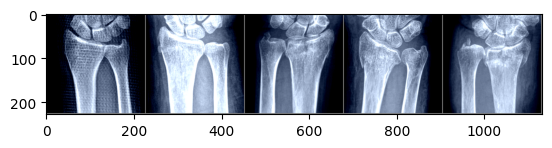

In [295]:
preap_test_dataloader

dataiter = iter(preap_test_dataloader)
images, labels = next(dataiter)

# Test 이미지를 출력
imshow(torchvision.utils.make_grid(images))

In [301]:
correct = 0
total = 0
with torch.no_grad():
    for data in preap_test_dataloader:
        
        images, labels = data
        
        net.eval()
        
        # GPU가 사용가능하면 GPU에 데이터 전송
        net.to(device)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


# 6. 모델 저장 및 로드

In [297]:
save_path = './weights_transfer_learning.pth'
torch.save(net.state_dict(), save_path) # 저장할 파라미터, 경로

In [298]:
load_path = './weights_transfer_learning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

# GPU에 저장된 가중치를 CPU에 로드하는 경우
load_weights = torch.load(load_path, map_location={'cuda:0': 'cpu'})
net.load_state_dict(load_weights)

<All keys matched successfully>